In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
from env.gelateria_env import GelateriaEnv
from env.gelateria import default_init_state, init_state_from
from env.reward.simple_reward import SimpleReward
from models.mlp_sales import MLPLogSalesModel
from data_generators.data_generators import DataGenerator
from utils.config import DataGenerationConfig, DataLoaderConfig, LightningConfig, NetConfig
import pytorch_lightning as pl
from env.gelateria import GelateriaState, Gelato
from utils.enums import Flavour
from models.ucb import UCB
from models.mc_control import MCControl
from models.td_0 import TDZero

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import logging

logging.basicConfig(level=logging.INFO)

/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <3F789787-FE38-3CE7-8599-064BDD0416EE> /Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <3F9923D2-81A5-3EC8-9739-EC0C1C816132> /Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [3]:
single_product = [Gelato(Flavour.MINT, 1, 100)]
init_state = init_state_from(single_product)
init_state.day_number = 100

In [4]:
mlp_model = MLPLogSalesModel(input_dim=14, name="mlp_block", config=NetConfig())

mlp_model.load()

In [5]:
env = GelateriaEnv(init_state=init_state,
                    reward=SimpleReward(),
                    sales_model=mlp_model,)


In [10]:
q_init = np.tile(5 * np.ones((1, 101)) - np.linspace(0, 5, 101), (1, 101, 1))

td = TDZero(env, n_episodes=100_000, horizon_steps=100, epsilon=0.7, alpha=0.1,
            warm_start=150)

td.train()

INFO:models.td_0:Warm starting for 150 steps.
100%|██████████| 100000/100000 [10:46<00:00, 154.74it/s]


In [6]:
days = np.linspace(0, 1, 365)
stock = np.array([1]*365)
price = np.array([1]*365)
markdown = [np.array([.1*i]*365) for i in range(10)]
one_hot = np.array([[1,0,0,0,0,0,0,0,0,0]]*365)

data = [np.vstack([days, stock, price, markdown]).T for markdown in markdown]
input = [torch.tensor(np.concatenate([data, one_hot], axis=1), dtype=torch.float32) for data in data]
t = torch.rand((100, 14))

In [7]:
st_d = torch.load("/Users/UK45546573/dev/gelato_env/experiment_data/trained_models/mlp_sales_model.pt")
mlp_model._model.load_state_dict(st_d)

a = [mlp_model.get_sales(input) for input in input]

df = df.iloc[:365]
for i in range(10):
    df[f"preds_{i}"] = a[i]

NameError: name 'df' is not defined

In [ ]:
f = df.plot("day", ["sales"] + [f"preds_{i}" for i in range(10)])
fig = f.get_figure()
fig.savefig("/Users/UK45546573/Documents/pydata23/preds_temp.png", dpi=300)
plt.show()

In [8]:
env.reset()

({'public_obs': tensor([[0.2740, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]),
  'private_obs': {'sales': tensor([[6.7269]])}},
 {UUID('54e70bfe-d8d8-4627-b6a4-1cd2367a4c7f'): None},
 False,
 {'global_reward': 0.0})

In [9]:
q_init = np.tile(5*np.ones((1, 101)) - np.linspace(0, 5, 101), (1, 101, 1))


td = TDZero(env, n_episodes=20_000, horizon_steps=100, epsilon=0.7, alpha=0.1,
            warm_start=150)


In [11]:
td.train()

INFO:models.td_0:Warm starting for 150 steps.
  0%|          | 0/20000 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object is not iterable

In [11]:
td.q_values_mean_normalised

array([[ 0.76271172, -0.9348789 , -0.68576458, ..., -0.37278383,
        -2.10781964, -0.46963207],
       [-1.87224468, -0.70735793, -2.89183599, ..., -0.8092628 ,
        -0.25091399, -0.962483  ],
       [ 0.04457075, -1.27288809, -1.14565165, ..., -0.63825758,
        -2.42605049, -0.99845577],
       ...,
       [14.53961706, 14.49567482, 14.48394841, ..., 15.44718028,
        15.28217603, 15.39425656],
       [-3.05615182, -1.19166733, -0.74616216, ..., -1.29624168,
        -1.40649126, -1.03837778],
       [-1.13589742, -1.92537359, -0.97002126, ..., 15.67463761,
        15.38547398, 12.67817331]])

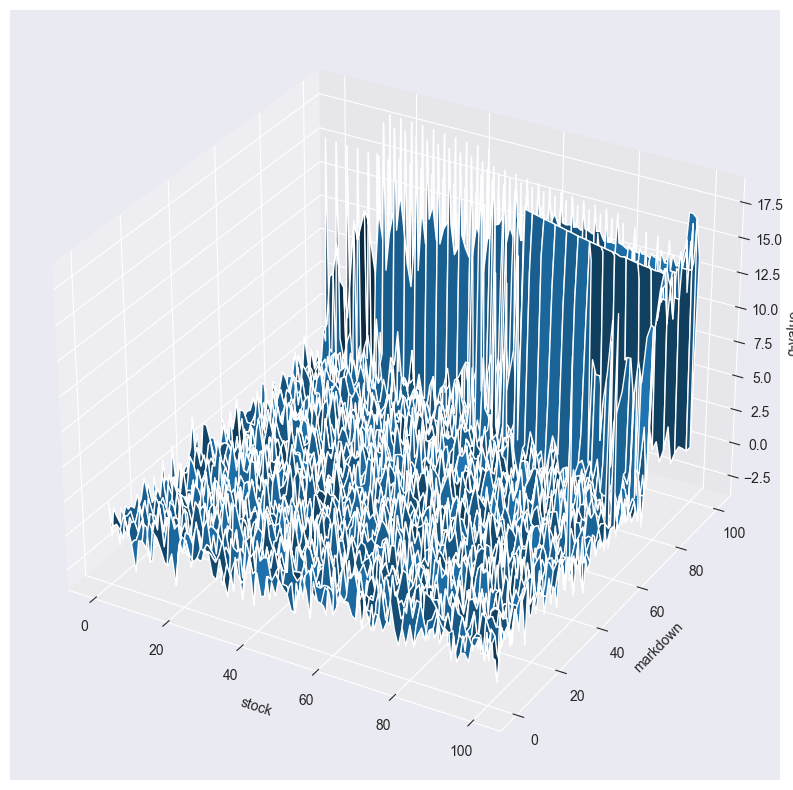

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

X,Y = np.meshgrid(np.arange(0, 101), np.arange(0, 101))
Z = td.q_values

surf = ax.plot_surface(X, Y, Z, antialiased=True)
ax.set_xlabel("stock")
ax.set_ylabel("markdown")
ax.set_zlabel("q-value")

#plt.savefig("/Users/UK45546573/Documents/pydata23/td_q_values_temp_from_qinit.png", dpi=300)
plt.show()

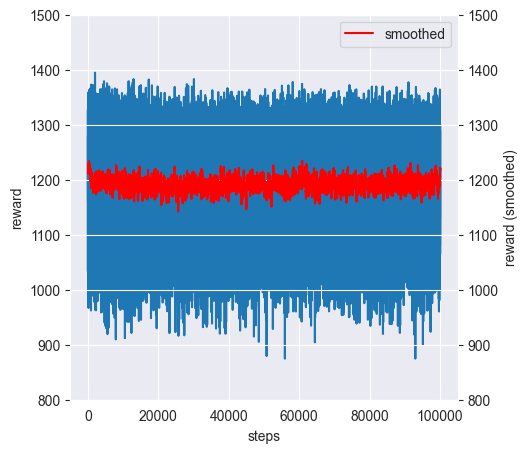

In [133]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
x = np.arange(0, len(td._rewards))
y2 = np.convolve(np.array(td._rewards).squeeze(), np.ones((100,))/100, mode='valid')

ax.plot(x, td._rewards)
ax2.plot(x[99:], y2, color="red", label="smoothed")

y_ticks = ax.get_yticks()
ax2.set_yticks(y_ticks)

# Adjust the tick alignment
ax.set_yticks(ax.get_yticks())
ax2.set_yticks(ax2.get_yticks())

ax.set_xlabel("steps")
ax.set_ylabel("reward")
ax2.set_ylabel("reward (smoothed)")

plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

X,Y = np.meshgrid(np.arange(0, 101), np.arange(0, 70))
Z = td._rewards

surf = ax.plot_surface(X, Y, Z.T, antialiased=True)
ax.set_xlabel("stock")
ax.set_ylabel("markdown")


In [164]:
n_episodes = 100_000
horizon_steps = 100
epsilon = 0.9
warm_start = 150
mc = MCControl(env, n_episodes=n_episodes, horizon_steps=horizon_steps,
               epsilon=epsilon, warm_start=warm_start)

[autoreload of env.reward.simple_reward failed: Traceback (most recent call last):
  File "/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 333, in update_class
    if update_generic(old_obj, new_obj):
  File "/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/Users/UK45546573/miniforge3/envs/rl

In [159]:
mc.train()

INFO:models.mc_control:Warm starting for 150 steps.
100%|██████████| 50000/50000 [12:47<00:00, 65.15it/s]


In [160]:
mc.q_values

array([[ 1.13217524e+02,  1.11390694e+02,  1.13038482e+02, ...,
         1.13125311e+02,  1.12706593e+02,  1.12711433e+02],
       [ 1.24934347e+02,  1.22839596e+02,  1.25518609e+02, ...,
         1.24986597e+02,  1.22705291e+02,  1.24074041e+02],
       [ 1.04273917e+02,  1.19041061e+02,  9.24593350e+01, ...,
         1.24396400e+02,  1.26291742e+02,  1.24687500e+02],
       ...,
       [ 7.46466338e+01,  7.58813628e+01,  7.50378864e+01, ...,
         7.28429369e+01,  7.30210553e+01,  7.30256424e+01],
       [ 3.23415170e-01, -2.18798405e-01, -4.14694582e-01, ...,
         6.34321014e-02,  2.70954417e-01,  6.18189868e-01],
       [ 1.57448972e+02,  1.54316416e+02,  1.54529967e+02, ...,
         1.18361882e+02,  1.24419978e+02,  1.21609393e+02]])

In [130]:
mc.q_values[0,1]

103.82623780050943

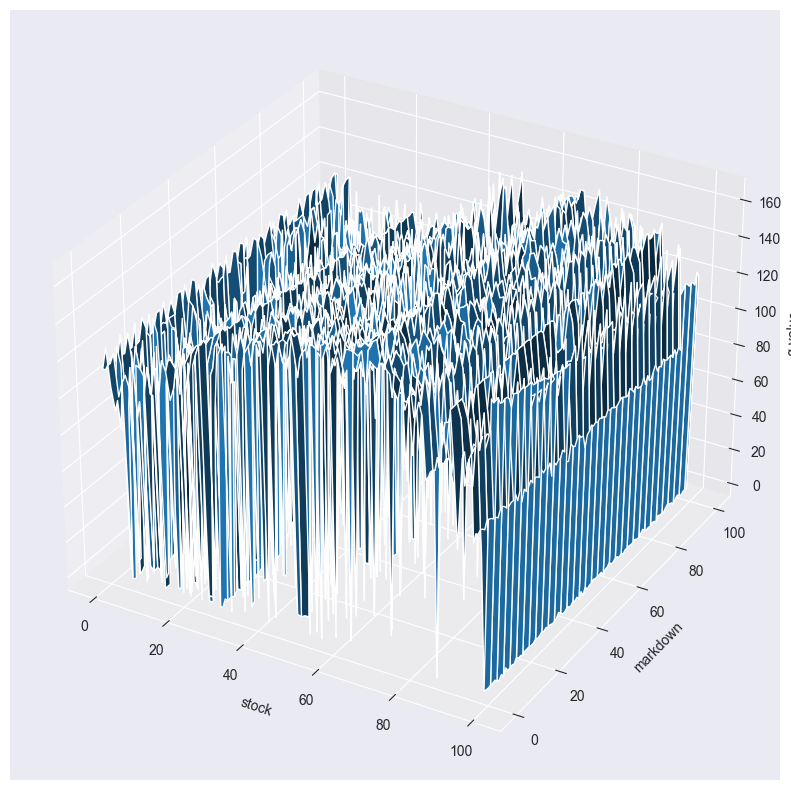

In [163]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

X,Y = np.meshgrid(np.arange(0, 101), np.arange(0, 101))
Z = mc.q_values

surf = ax.plot_surface(X, Y, Z.T, antialiased=True)
ax.set_xlabel("stock")
ax.set_ylabel("markdown")
ax.set_zlabel("q-value")
plt.savefig(f"/Users/UK45546573/Documents/pydata23/mc_q_values_{n_episodes}_"
            f"{horizon_steps}_{warm_start}.png", dpi=300)
plt.show()

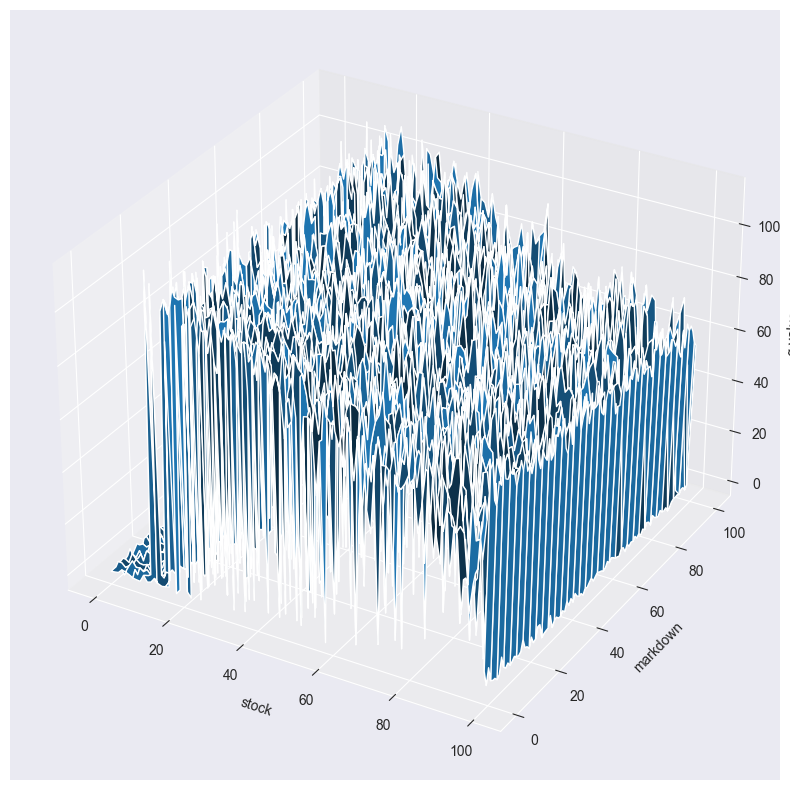

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

X,Y = np.meshgrid(np.arange(0, 101), np.arange(0, 101))
Z = mc.q_values

surf = ax.plot_surface(X, Y, Z.T, antialiased=True)
ax.set_xlabel("stock")
ax.set_ylabel("markdown")
ax.set_zlabel("q-value")
plt.savefig("/Users/UK45546573/Documents/pydata23/q_values_temp_4.png", dpi=300)
plt.show()

In [ ]:
from scipy import interpolate
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

tck = interpolate.bisplrep(X, Y, Z, s=0)
Z_smooth = interpolate.bisplev(X, Y, tck)

surf_2 = ax.plot_surface(X, Y, Z_smooth, antialiased=True)
ax.set_xlabel("stock")
ax.set_ylabel("markdown")
ax.set_zlabel("q-value")
plt.savefig("/Users/UK45546573/Documents/pydata23/q_values_smooth.png", dpi=300)
plt.show()

In [ ]:
mc._rewards

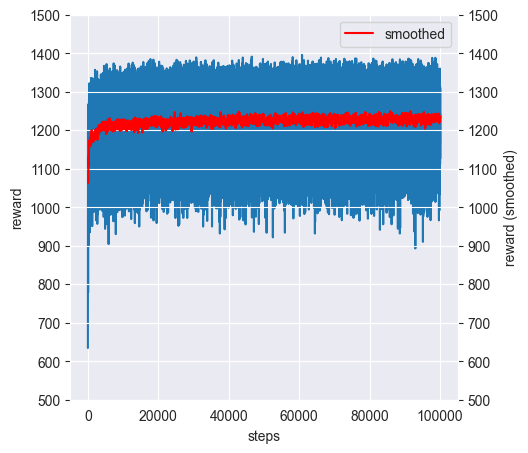

In [132]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
x = np.arange(0, len(mc._rewards))
y2 = np.convolve(np.array(mc._rewards).squeeze(), np.ones((100,))/100, mode='valid')

ax.plot(x, mc._rewards)
ax2.plot(x[99:], y2, color="red", label="smoothed")

y_ticks = ax.get_yticks()
ax2.set_yticks(y_ticks)

# Adjust the tick alignment
ax.set_yticks(ax.get_yticks())
ax2.set_yticks(ax2.get_yticks())

ax.set_xlabel("steps")
ax.set_ylabel("reward")
ax2.set_ylabel("reward (smoothed)")

plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
x = np.arange(0, len(mc._discounted_rewards))
ax.plot(x, np.array(mc._discounted_rewards).squeeze())

ax.set_xlabel("episodes")
ax.set_ylabel("reward")
plt.show()

In [137]:
import pandas as pd

df = pd.read_csv("/Users/UK45546573/dev/gelato_env/experiment_data/experiment_data.csv")

In [138]:
df

day     flavour  price  stock  markdown  _expected_sales  _prob_sales  \
0      0  strawberry    1.0    100      0.30                0     1.333877   
1      1  strawberry    1.0    100      0.50                0     1.664895   
2      2  strawberry    1.0    100      0.23                0     1.341440   
3      3  strawberry    1.0    100      0.25                0     1.360428   
4      4  strawberry    1.0    100      0.11                1     1.192949   
..   ...         ...    ...    ...       ...              ...          ...   
360  360  strawberry    1.0    100      0.32                0     1.416030   
361  361  strawberry    1.0    100      0.69                1     1.834165   
362  362  strawberry    1.0    100      0.68                1     1.713137   
363  363  strawberry    1.0    100      0.50                0     1.550564   
364  364  strawberry    1.0    100      0.57                0     1.655210   

        sales  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    1.192949  
..        ...  
360  0.000000  
361  1.834165  
362  1.713137  
363  0.000000  
364  0.000000  

[365 rows x 8 columns]

In [ ]:
ucb = UCB(env, horizon_steps=100_000)

In [ ]:
ucb.train()

In [ ]:
ucb_flat = [y for x in ucb._actions for y in x]

In [ ]:
ucb_flat

In [ ]:
plt.hist(ucb_flat)

In [ ]:
mlp_model = MLPLogSalesModel(input_dim=14, name="mlp_block", config=NetConfig())


In [ ]:
mlp_model.named_children()

In [ ]:
env = GelateriaEnv(init_state=default_init_state(),
                reward=SimpleReward(),
                sales_model=mlp_model,)

In [ ]:
obs, _, _, _ = env.step([0,0,0])

In [ ]:
env.state.products["vanilla"].stock

In [167]:
from pytorch_lightning.callbacks import ModelCheckpoint

dg_config = DataGenerationConfig()
dl_config = DataLoaderConfig()
dl_config.batch_size = 16
l_config = LightningConfig()
model_config = NetConfig()
model_name = "mlp_block"
path = model_config.path_to_model / model_name
l_config.callbacks = [ModelCheckpoint(dirpath=path, save_top_k=2,
                                      monitor="mean_loss_val")]
dg_config.time_period_in_days = 365

In [168]:
dg = DataGenerator(dg_config, dl_config)

In [169]:
dg.load("/Users/UK45546573/dev/gelato_env/experiment_data/experiment_data.csv")

In [170]:
df = dg._generate()
df.rename(columns={"_expected_sales": "expected_sales"}, inplace=True)
df.__len__()

365

<AxesSubplot: xlabel='day'>

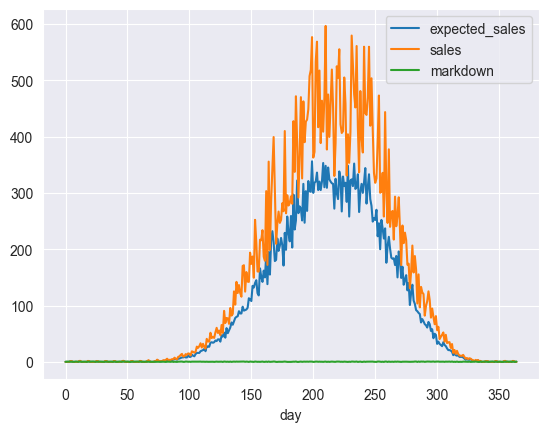

In [172]:
df.plot("day", ["expected_sales","sales", "markdown"])

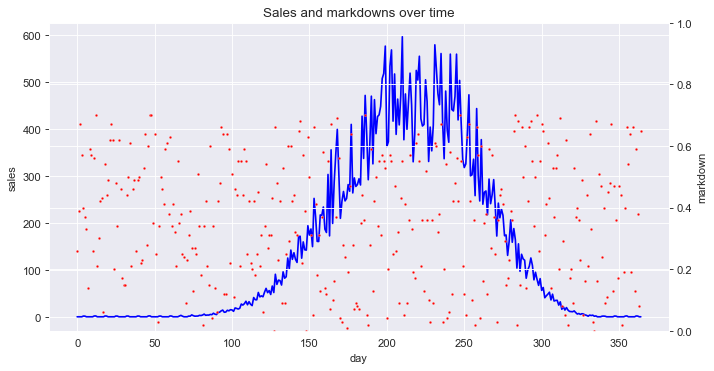

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax_2 = ax.twinx()

sns.set_style("darkgrid")
sns.lineplot(data=df, x="day", y="sales", ax=ax, color="blue")
sns.scatterplot(data=df, x="day", y="markdown", s=5, ax=ax_2, color="red")

ax_2.set_ylim([0,1])

ax.set_ylabel("sales")
ax_2.set_ylabel("markdown")
ax.set_xlabel("day")
plt.title("Sales and markdowns over time")
plt.savefig("/Users/UK45546573/Documents/pydata23/sales_markdowns.png", dpi=300)
plt.show()

In [ ]:
a, _ = dg.get_train_val_dataloaders()

In [ ]:
next(iter(a))["public_obs"].shape[-1]

In [ ]:
df.iloc[320]

In [147]:
a,b = dg.get_train_val_dataloaders()

In [7]:
len(iter(a).__next__()[0])

NameError: name 'a' is not defined

In [149]:
l_config.max_epochs = 100
l_config.accelerator = "mps"

mlp_model = MLPLogSalesModel(input_dim=14, name=model_name, config=model_config)

trainer = pl.Trainer(**l_config.to_dict())
trainer.fit(model=mlp_model,
            train_dataloaders=a,
            val_dataloaders=b)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /Users/UK45546573/dev/gelato_env/experiment_data/trained_models/mlp_block exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name   | Type          | Params
-----------------------------------------
0 | _model | SalesMLPBlock | 2.8 K 
-----------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/UK45546573/miniforge3/envs/rl-dev-macos/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
mlp_model.get_sales(obs["public_obs"])

In [ ]:
mlp_model.save()

In [5]:
%reload_ext tensorboard

In [6]:
%tensorboard --logdir=/Users/UK45546573/dev/gelato_env/experiment_data/training_logs/lightning_log

Launching TensorBoard...

In [ ]:
from utils.misc import get_root_dir

get_root_dir()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
img = cv2.imread("/Users/UK45546573/Documents/pydata23/ice_cream_shop_base.jpg", 0)

In [ ]:
img.shape

In [ ]:
uni_noise = np.zeros_like(img)
cv2.randu(uni_noise, 0, 255)
uni_noise = (.3*uni_noise).astype(np.uint8)

In [ ]:
un_img = cv2.add(img, uni_noise)

In [ ]:
plt.imshow(un_img, cmap="gray")
plt.axis("off")

In [ ]:
import torch

from data_generators.generator import Generator


class SigmoidGaussian(Generator):
    """
    A class that generates a sigmoid function with a gaussian noise component. Used to generate probabilities of sales
    of a product at a given markdown.
    """

    def __init__(self, mean: float = .1, std: float = .05):
        self._background = lambda x: torch.sigmoid(5 * x - 2.5)
        self._noise = torch.distributions.Normal(loc=mean, scale=std)

    def prob_sales_at_reduction(self, reductions: torch.Tensor) -> torch.Tensor:
        return torch.clip((self._noise.sample(sample_shape=reductions.shape) + self._background(reductions)),
                          min=0, max=2)


In [ ]:
sg_gen = SigmoidGaussian()
probs = sg_gen.prob_sales_at_reduction(torch.linspace(0, 1, 101))

In [ ]:
plt.plot(probs)

In [ ]:
torch.linspace(0, 1, 101)

In [137]:
import cv2


In [138]:
img = cv2.imread("/Users/UK45546573/Documents/pydata23/ice_cream_shop_base.jpg", 0)

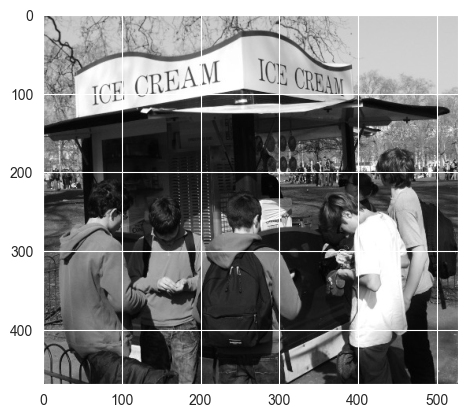

In [141]:
plt.imshow(img, cmap="gray")

In [143]:
gaussian_noise = np.zeros_like(img)
cv2.randn(gaussian_noise, 0, 255)
gaussian_noise = (.15*gaussian_noise).astype(np.uint8)

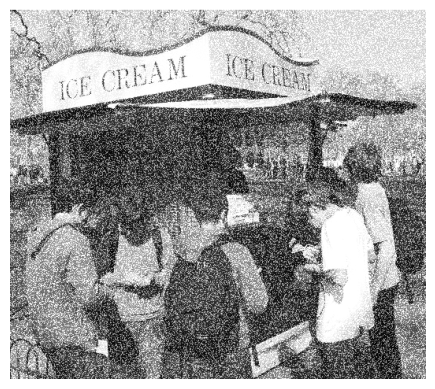

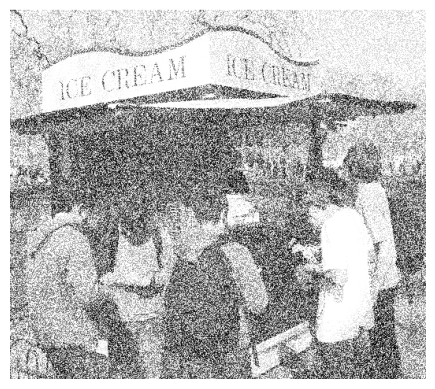

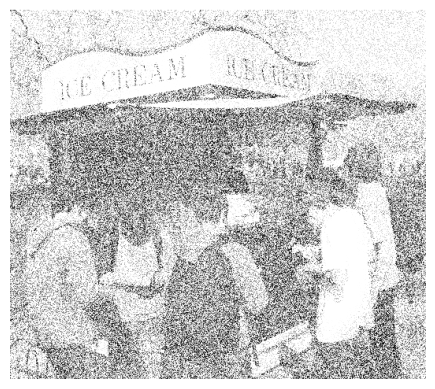

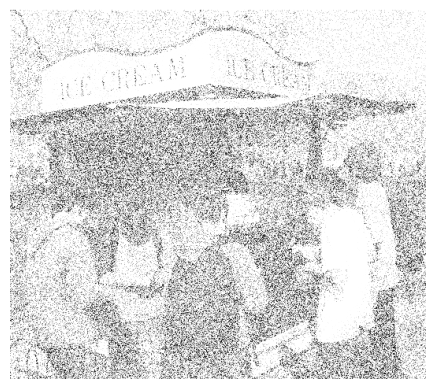

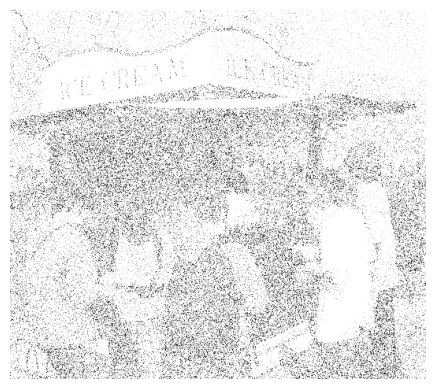

In [150]:
img = cv2.imread("/Users/UK45546573/Documents/pydata23/ice_cream_shop_base.jpg", 0)
for idx in range(5):
    gaussian_noise = np.zeros_like(img)
    cv2.randn(gaussian_noise, 0, 255)
    gaussian_noise = (.6*gaussian_noise).astype(np.uint8)
    img = cv2.add(img, gaussian_noise)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.savefig(f"/Users/UK45546573/Documents/pydata23/ice_cream_shop_base_{idx}.png", dpi=300)
    plt.show()


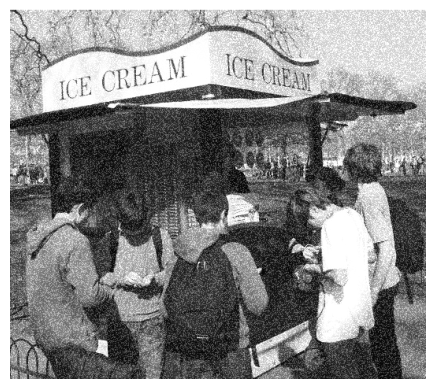

In [151]:
img = cv2.imread("/Users/UK45546573/Documents/pydata23/ice_cream_shop_base.jpg", 0)
gaussian_noise = np.zeros_like(img)
cv2.randn(gaussian_noise, 0, 255)
gaussian_noise = (.3*gaussian_noise).astype(np.uint8)
img = cv2.add(img, gaussian_noise)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.savefig(f"/Users/UK45546573/Documents/pydata23/ice_cream_shop_base_orig.png",
            dpi=300)
plt.show()
